In [401]:
!pip install pyvi

# Chuẩn bị thư viện và các chức năng xử lý

In [402]:
import numpy as np
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
import pandas as pd
import seaborn as sns

np.random.seed(42) # Cố định kết quả
# Hàm tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower()  # Chuyển thành chữ thường
    cleaned_text = ''.join(char for char in text if char.isalnum() or char.isspace())  # Loại bỏ ký tự đặc biệt
    words = ViTokenizer.tokenize(cleaned_text).split()  # Tách từ tiếng Việt
    return words

# Hàm xây dựng từ điển từ vựng
def build_vocab(sentences):
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab

# Hàm tính softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


# Hàm tính cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9))


# Hàm huấn luyện Skip-gram
def train_skipgram(sentences, vocab, epochs, learning_rate):
    window_size = 2
    vocab_size = len(vocab)
    embedding_dim = 100

    # Khởi tạo trọng số
    W1 = np.random.rand(vocab_size, embedding_dim)
    W2 = np.random.rand(embedding_dim, vocab_size)

    # Theo dõi mất mát qua các epoch
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0

        for sentence in sentences:
            sentence_len = len(sentence)
            for idx, word in enumerate(sentence):
                word_idx = vocab[word]

                # Lấy ngữ cảnh xung quanh từ trung tâm
                context_indices = list(range(max(0, idx - window_size), min(sentence_len, idx + window_size + 1)))
                context_indices.remove(idx)

                for context_idx in context_indices:
                    context_word = sentence[context_idx]
                    context_word_idx = vocab[context_word]

                    # Forward pass
                    h = W1[word_idx]  # Nhúng từ trung tâm
                    u = np.dot(W2.T, h)  # Ma trận đầu ra
                    y_pred = softmax(u)

                    # Tạo vector nhãn one-hot
                    y_true = np.zeros(vocab_size)
                    y_true[context_word_idx] = 1

                    # Tính loss
                    loss = cross_entropy_loss(y_true, y_pred)
                    total_loss += loss

                    # Backpropagation
                    e = y_pred - y_true
                    W2 -= learning_rate * np.outer(h, e)
                    W1[word_idx] -= learning_rate * np.dot(W2, e)

        # Ghi nhận mất mát
        loss_history.append(total_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss}")

    return W1, W2, loss_history

# Hàm dự đoán ngữ cảnh từ từ trung tâm
def predict_context(center_word, vocab, W1, W2, top_n):
    if center_word not in vocab:
        print(f"Từ '{center_word}' không có trong từ điển!")
        return []

    word_idx = vocab[center_word]
    h = W1[word_idx]  # Vector nhúng của từ trung tâm
    u = np.dot(W2.T, h)  # Tính xác suất
    y_pred = softmax(u)

    # Lấy top_n từ có xác suất cao nhất
    context_indices = np.argsort(y_pred)[::-1][:top_n]
    context_words = [word for word, idx in vocab.items() if idx in context_indices]
    return context_words

# Chuẩn bị mẫu dữ liệu

In [403]:
texts = [
    "Hà Nội, trái tim của Việt Nam, là nơi lưu giữ những giá trị văn hóa, lịch sử lâu đời. Đi dọc 36 phố phường, du khách sẽ cảm nhận được sự kết hợp hài hòa giữa nét cổ kính của phố cổ và vẻ hiện đại của một đô thị đang phát triển."
]

# Tiền xử lý dữ liệu

In [404]:
# Tiền xử lý dữ liệu
processed_texts = [preprocess_text(text) for text in texts]
vocab = build_vocab(processed_texts)
print(processed_texts)
print(vocab)

[['hà_nội', 'trái_tim', 'của', 'việt', 'nam', 'là', 'nơi', 'lưu_giữ', 'những', 'giá_trị', 'văn_hóa', 'lịch_sử', 'lâu_đời', 'đi', 'dọc', '36', 'phố_phường', 'du_khách', 'sẽ', 'cảm_nhận', 'được', 'sự', 'kết_hợp', 'hài_hòa', 'giữa', 'nét', 'cổ_kính', 'của', 'phố', 'cổ', 'và', 'vẻ', 'hiện_đại', 'của', 'một', 'đô_thị', 'đang', 'phát_triển']]
{'hà_nội': 0, 'trái_tim': 1, 'của': 2, 'việt': 3, 'nam': 4, 'là': 5, 'nơi': 6, 'lưu_giữ': 7, 'những': 8, 'giá_trị': 9, 'văn_hóa': 10, 'lịch_sử': 11, 'lâu_đời': 12, 'đi': 13, 'dọc': 14, '36': 15, 'phố_phường': 16, 'du_khách': 17, 'sẽ': 18, 'cảm_nhận': 19, 'được': 20, 'sự': 21, 'kết_hợp': 22, 'hài_hòa': 23, 'giữa': 24, 'nét': 25, 'cổ_kính': 26, 'phố': 27, 'cổ': 28, 'và': 29, 'vẻ': 30, 'hiện_đại': 31, 'một': 32, 'đô_thị': 33, 'đang': 34, 'phát_triển': 35}


# Huấn luyện

In [405]:
# Huấn luyện mô hình
W1, W2, loss_history = train_skipgram(processed_texts, vocab, epochs=100, learning_rate=0.01)

Epoch 1/100, Loss: 633.874192170858
Epoch 2/100, Loss: 572.4067780210846
Epoch 3/100, Loss: 543.4951811039585
Epoch 4/100, Loss: 520.7725821121732
Epoch 5/100, Loss: 501.01491541280814
Epoch 6/100, Loss: 483.3091327227625
Epoch 7/100, Loss: 467.0265279507942
Epoch 8/100, Loss: 451.7972315084516
Epoch 9/100, Loss: 437.4695815533288
Epoch 10/100, Loss: 423.97821640609936
Epoch 11/100, Loss: 411.2843238984764
Epoch 12/100, Loss: 399.3582102450661
Epoch 13/100, Loss: 388.1737820325275
Epoch 14/100, Loss: 377.70617053374485
Epoch 15/100, Loss: 367.93043434182624
Epoch 16/100, Loss: 358.8208035319909
Epoch 17/100, Loss: 350.3502889260166
Epoch 18/100, Loss: 342.49056970676025
Epoch 19/100, Loss: 335.21209148944115
Epoch 20/100, Loss: 328.4843094362253
Epoch 21/100, Loss: 322.27601457816183
Epoch 22/100, Loss: 316.5556909010537
Epoch 23/100, Loss: 311.29186502183376
Epoch 24/100, Loss: 306.45342606248613
Epoch 25/100, Loss: 302.00990695345416
Epoch 26/100, Loss: 297.93172734799856
Epoch 27/10

# Kết quả

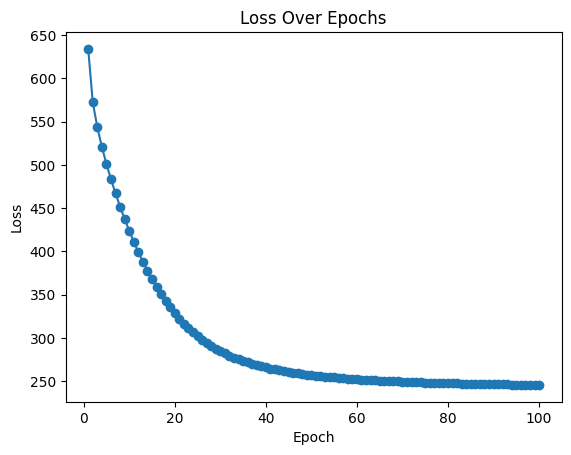

In [406]:
# Hiển thị kết quả mất mát
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.show()

In [407]:
for center_word in vocab.keys():
    predicted_context = predict_context(center_word, vocab, W1, W2, top_n=1)
    print(f"Ngữ cảnh dự đoán cho từ '{center_word}': {predicted_context}")

Ngữ cảnh dự đoán cho từ 'hà_nội': ['của']
Ngữ cảnh dự đoán cho từ 'trái_tim': ['việt']
Ngữ cảnh dự đoán cho từ 'của': ['đô_thị']
Ngữ cảnh dự đoán cho từ 'việt': ['là']
Ngữ cảnh dự đoán cho từ 'nam': ['nơi']
Ngữ cảnh dự đoán cho từ 'là': ['lưu_giữ']
Ngữ cảnh dự đoán cho từ 'nơi': ['những']
Ngữ cảnh dự đoán cho từ 'lưu_giữ': ['giá_trị']
Ngữ cảnh dự đoán cho từ 'những': ['văn_hóa']
Ngữ cảnh dự đoán cho từ 'giá_trị': ['lịch_sử']
Ngữ cảnh dự đoán cho từ 'văn_hóa': ['lâu_đời']
Ngữ cảnh dự đoán cho từ 'lịch_sử': ['đi']
Ngữ cảnh dự đoán cho từ 'lâu_đời': ['dọc']
Ngữ cảnh dự đoán cho từ 'đi': ['36']
Ngữ cảnh dự đoán cho từ 'dọc': ['phố_phường']
Ngữ cảnh dự đoán cho từ '36': ['du_khách']
Ngữ cảnh dự đoán cho từ 'phố_phường': ['sẽ']
Ngữ cảnh dự đoán cho từ 'du_khách': ['cảm_nhận']
Ngữ cảnh dự đoán cho từ 'sẽ': ['được']
Ngữ cảnh dự đoán cho từ 'cảm_nhận': ['sự']
Ngữ cảnh dự đoán cho từ 'được': ['kết_hợp']
Ngữ cảnh dự đoán cho từ 'sự': ['hài_hòa']
Ngữ cảnh dự đoán cho từ 'kết_hợp': ['giữa']
Ngữ cản

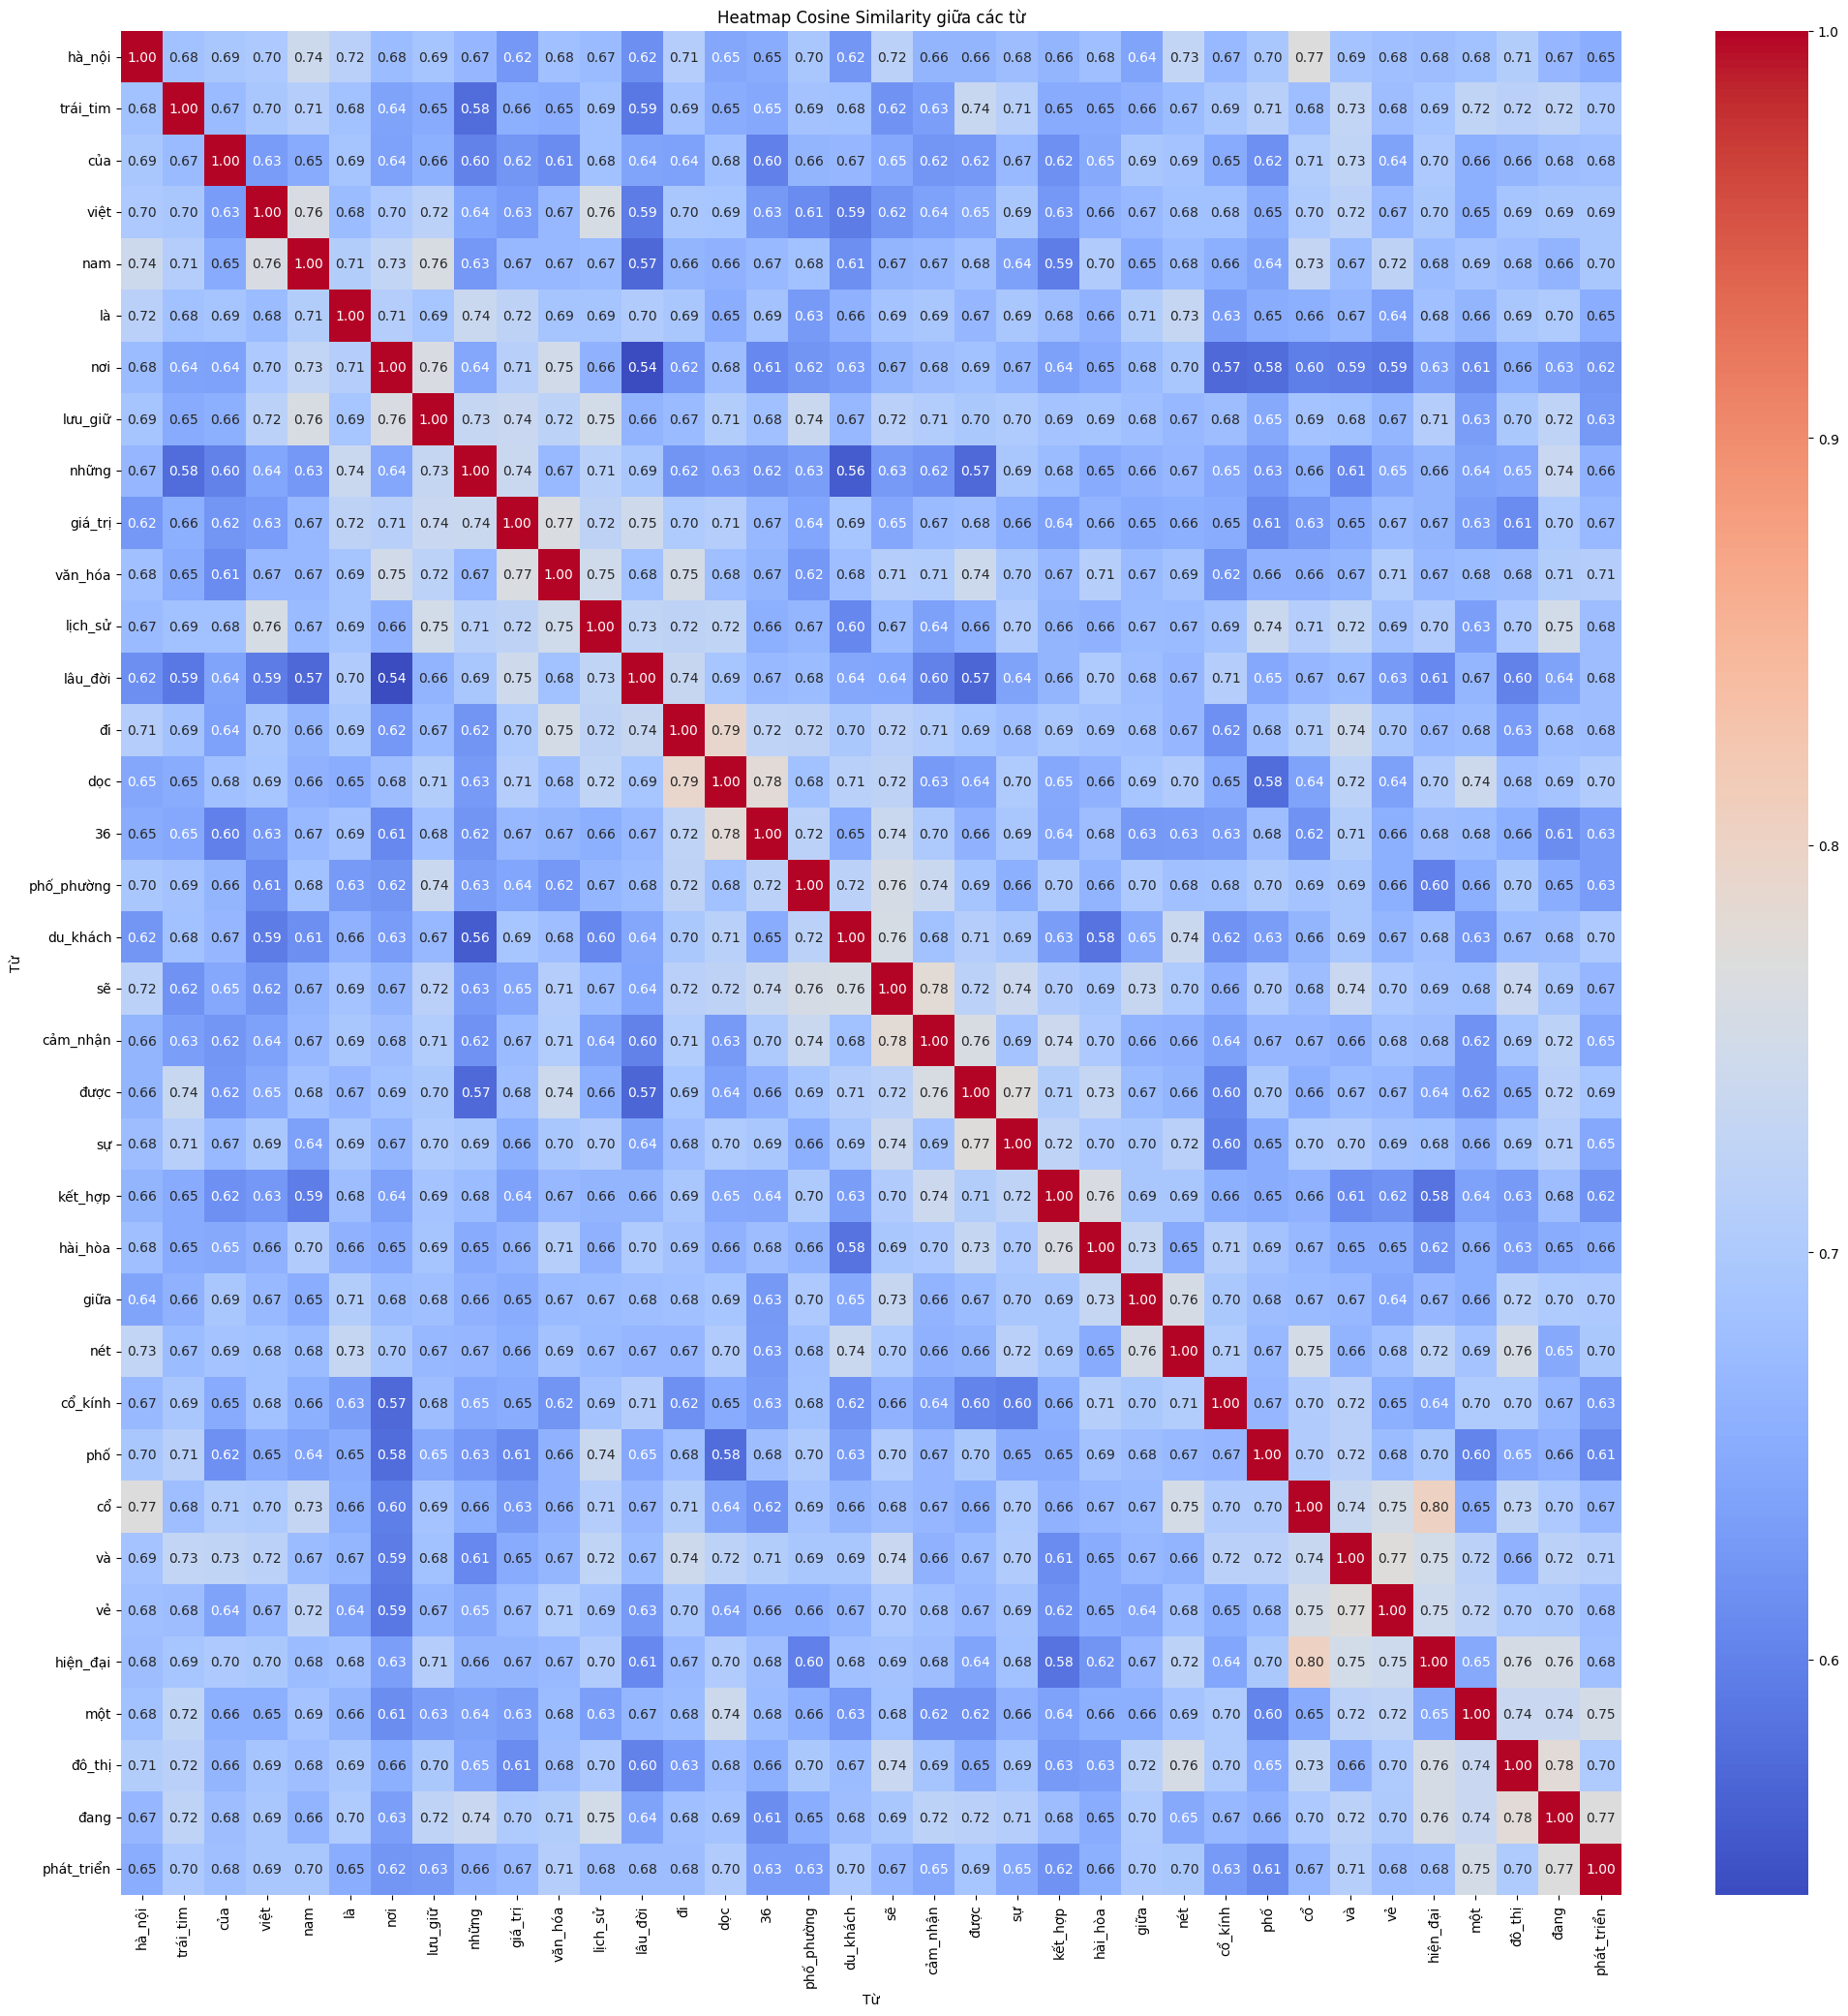

In [408]:
# Hàm tính cosine similarity giữa các vector nhúng
def compute_cosine_similarity(word1, word2, vocab, W1):
    if word1 not in vocab or word2 not in vocab:
        print(f"Không tìm thấy một trong các từ '{word1}' hoặc '{word2}' trong từ điển!")
        return None

    idx1, idx2 = vocab[word1], vocab[word2]
    vec1, vec2 = W1[idx1], W1[idx2]

    # Tính cosine similarity bằng numpy
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

# Hàm tính toán ma trận cosine similarity giữa tất cả các cặp từ
def compute_similarity_matrix(vocab, W1):
    similarity_matrix = np.zeros((len(vocab), len(vocab)))
    words = list(vocab.keys())

    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i <= j:  # Chỉ tính cho phần trên của ma trận (symmetric matrix)
                similarity = compute_cosine_similarity(word1, word2, vocab, W1)
                similarity_matrix[i][j] = similarity
                similarity_matrix[j][i] = similarity  # Ma trận đối xứng

    # Chuyển ma trận similarity thành DataFrame để dễ dàng hiển thị
    similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
    return similarity_df


# # Tính toán ma trận cosine similarity vào DF
similarity_df = compute_similarity_matrix(vocab, W1)
# Vẽ heatmap cosine similarity
plt.figure(figsize=(25, 25))
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap Cosine Similarity giữa các từ")
plt.xlabel("Từ")
plt.ylabel("Từ")
plt.show()

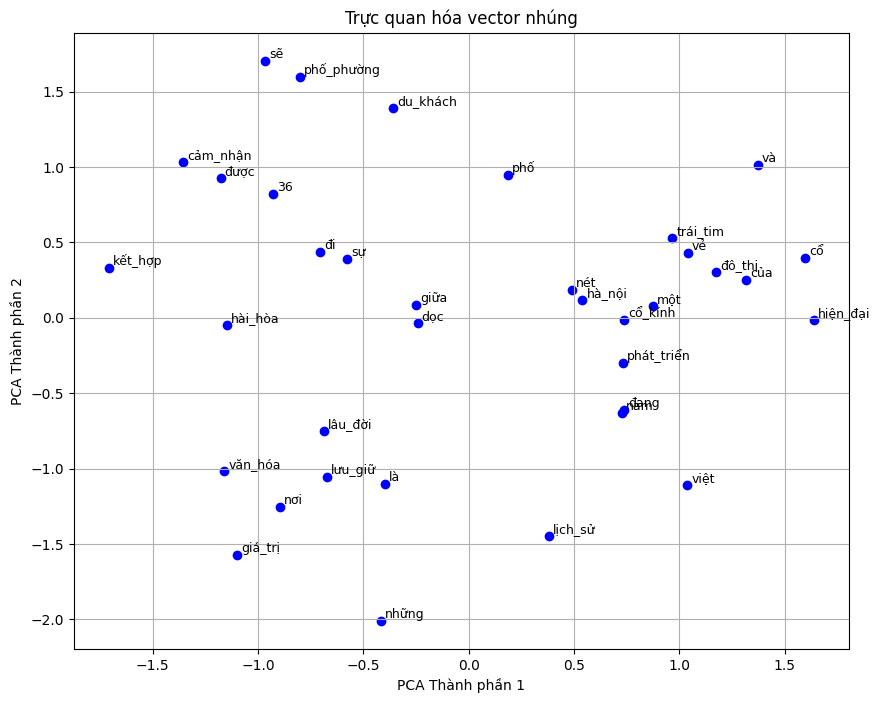

In [409]:
def pca_reduce(W1, n_components):
    # Chuẩn hóa ma trận nhúng (trung bình = 0)
    W1_mean = np.mean(W1, axis=0)
    W1_centered = W1 - W1_mean

    # Tính ma trận hiệp phương sai
    covariance_matrix = np.cov(W1_centered, rowvar=False)

    # Tính giá trị riêng và vector riêng
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sắp xếp giá trị riêng theo thứ tự giảm dần
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]

    # Dựng lại dữ liệu trong không gian mới
    reduced_embeddings = np.dot(W1_centered, top_eigenvectors)
    reduced_embeddings = np.real(reduced_embeddings)
    return reduced_embeddings


def visualize_embeddings(vocab, W1):
    reduced_embeddings = pca_reduce(W1, n_components=2)  # Giảm chiều xuống 2D

    # Vẽ biểu đồ scatter
    plt.figure(figsize=(10, 8))
    for word, idx in vocab.items():
        x, y = reduced_embeddings[idx]
        plt.scatter(x, y, marker='o', color='blue')
        plt.text(x + 0.02, y + 0.02, word, fontsize=9)

    plt.title("Trực quan hóa vector nhúng")
    plt.xlabel("PCA Thành phần 1")
    plt.ylabel("PCA Thành phần 2")
    plt.grid(True)
    plt.show()


# Gọi hàm để trực quan hóa vector nhúng
visualize_embeddings(vocab, W1)
